##Installation of SMAC and all its dependencies

This code snippet has to be called always if the runtime environment was canceled, e.g., after the notebook wasn't used for quite some time.

The installation of the `configspace` package and the `pyrfr` package can take some time (few minutes). 
(Note: The installation of the pyrfr is a bit troublesome; in particular in colab.)

In [3]:
!apt-get install swig -y
!pip install Cython
# actually, I have no clue how to install the pyrfr correctly
# some combination of the following commands
# should hopefully work
#!pip install pyrfr --no-cache
#!pip install pyrfr --no-cache --user
!pip install pyrfr==0.7.2 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")
#sys.path.insert(0,'/usr/local/lib/python3.6/dist-packages/')

# install SMAC development
!pip uninstall smac -y
!pip install git+https://github.com/automl/SMAC3.git@development
# to install the official release
#!pip install smac

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Uninstalling smac-0.8.0:
  Successfully uninstalled smac-0.8.0
Cannot uninstall requirement smac, not installed
Cannot uninstall requirement smac, not installed
  Cloning https://github.com/automl/SMAC3.git (to development) to /tmp/pip-t4tlvq0h-build
  Running setup.py install for smac ... - \ | done


## Running SMAC

Since we optimize an artificial, smooth, low-dimensional function,
we using a Random Forest with a fairly high resolution (i.e., many trees and without limited depth).

In [45]:
import math
import logging
import numpy as np

from smac.facade.func_facade import fmin_smac


def test_func(x):
    # x is vector; here of length 1
    x = x[0]
    return math.cos(x) * x**2 + x

# debug output
logging.basicConfig(level=20)
logger = logging.getLogger("Optimizer") # Enable to show Debug outputs

# use RF with higher resolution
types, bounds = np.array([0]), np.array([[0.0, 1.0]])
from smac.epm.rf_with_instances import RandomForestWithInstances
model = RandomForestWithInstances(types=types, 
                                  bounds=bounds,
                                  instance_features=None,
                                  seed=12345,
                                  pca_components=12345,
                                  ratio_features=1,
                                  num_trees=1000,
                                  min_samples_split=1,
                                  min_samples_leaf=1,
                                  max_depth=100000,
                                  do_bootstrapping=False,
                                  n_points_per_tree=-1,
                                  eps_purity=0
                                 )

x, cost, smac = fmin_smac(func=test_func,
                       x0=[-0, -0],
                       bounds=[(-5, 5)],
                       maxfun=15,
                       rng=1234,
                       model=model)

print("Best x: %s; with cost: %f"% (str(x), cost))

INFO:smac.scenario.scenario.Scenario:Output to smac3-output_2018-02-20_19:37:34_198538
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Challenger (-6.4971) is better than incumbent (0.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  x1 : 0.0 -> -2.382101700500938
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -6.4971
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -6.4971
INFO:smac.intensification.intensification.Intensifier:Challenger (-7.2826) is better than incumbent (-6.4971) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  x1 : -2.3821017005009

Best x: [-3.56301391]; with cost: -15.147371


In [0]:
# extracting the data from the runhistory
# SMAC also provides a function to extract all points 
# but this function is not order-preserving

import numpy as np
# get runhistory, all runs ever evaluated by smac
runhistory = smac.get_runhistory()

# extract x value and corresponding y value
x_smac = []
y_smac = []
for entry in runhistory.data: # iterate over data because it is an OrderedDict
  config_id = entry.config_id # look up config id
  config = runhistory.ids_config[config_id] # look up config
  y_ = runhistory.get_cost(config) # get cost
  x_ = config["x1"] # there is only one entry in our example
  x_smac.append(x_)
  y_smac.append(y_)
x_smac = np.array(x_smac)
y_smac = np.array(y_smac)

## Plotting all Evaluated Points

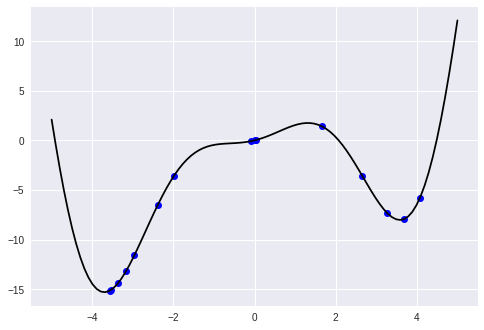

In [47]:
# plot test_func and all evaluated points
import numpy as np

x_points = np.linspace(start=-5,stop=5,num=100) # same range as the bounds above
y_points = list(map(test_func,map(lambda x: [x], x_points)))

import matplotlib.pyplot as plt
plt.plot(x_smac, y_smac, 'bo', x_points, y_points, 'k')

##Plotting every Step of SMAC

Each time step consists of two plots:
The first plot show the unknown function and all evaluated points on it
The second plot shows the acquisition function and the point chosen on it.

Please note ...

1. that every second point is chosen randomly (i.e., without optimizing the acquisition function).
2. SMAC hit the optimum by chance (because of random configuration).

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


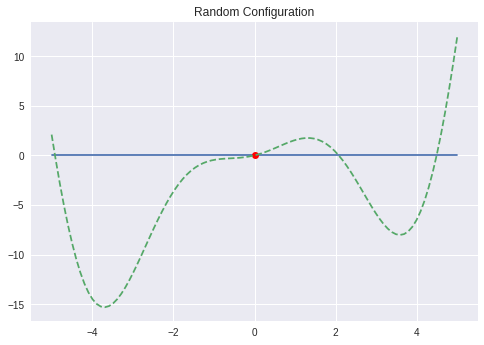

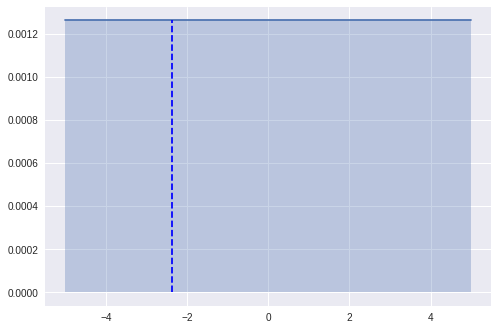

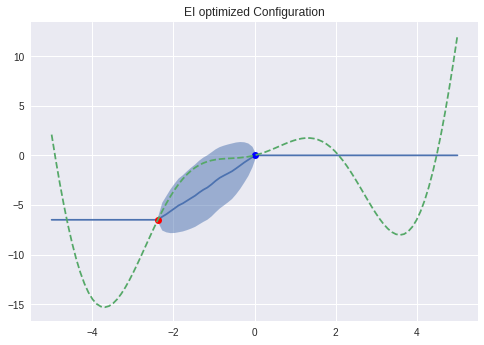

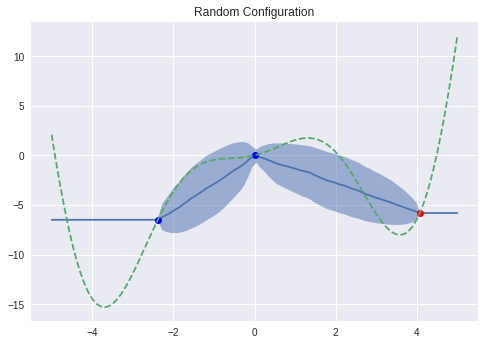

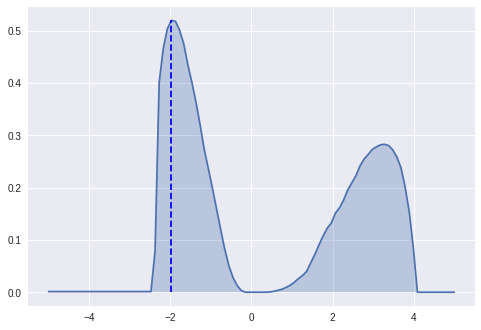

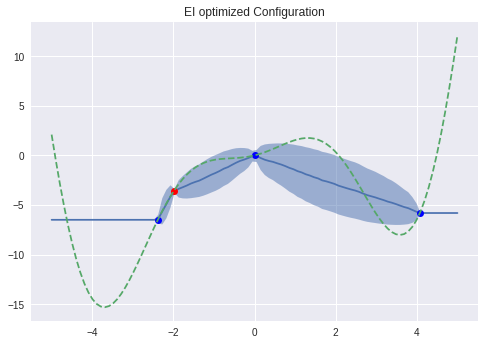

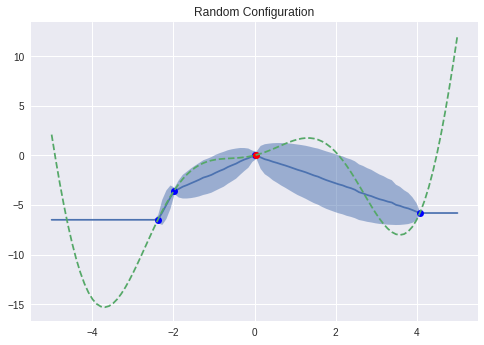

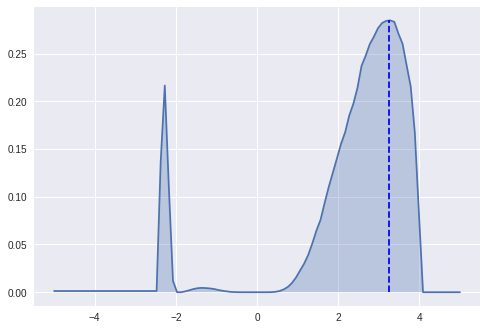

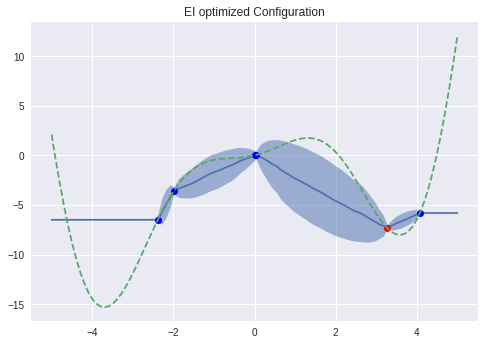

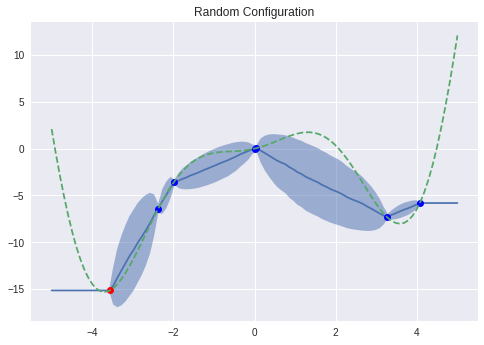

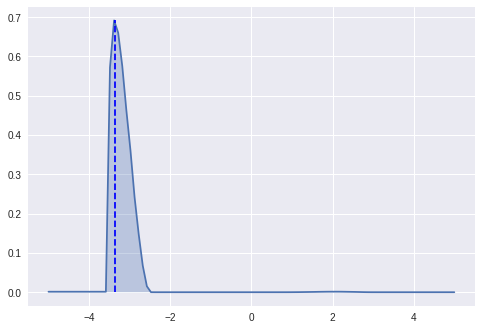

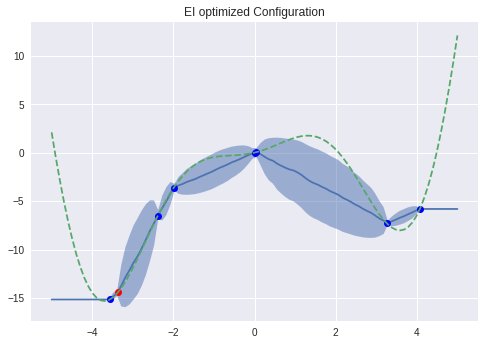

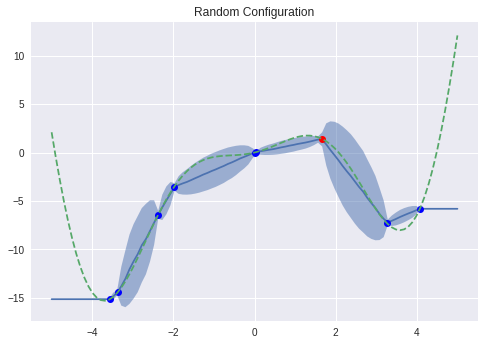

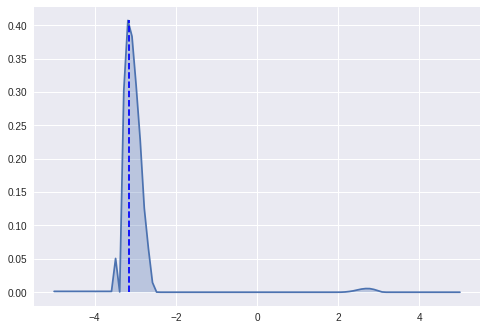

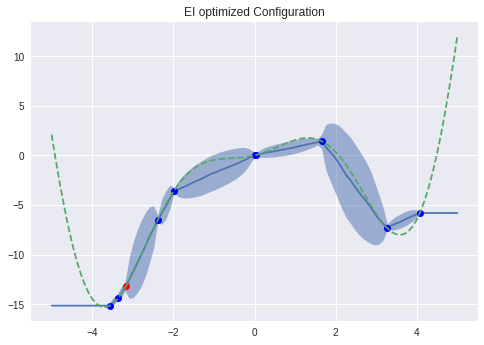

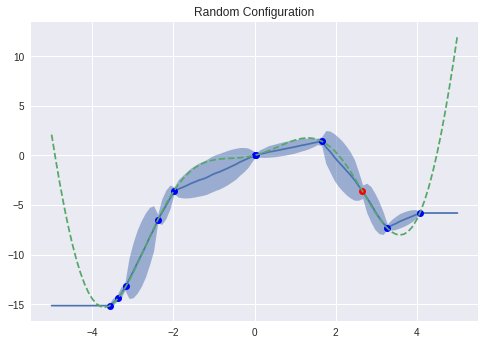

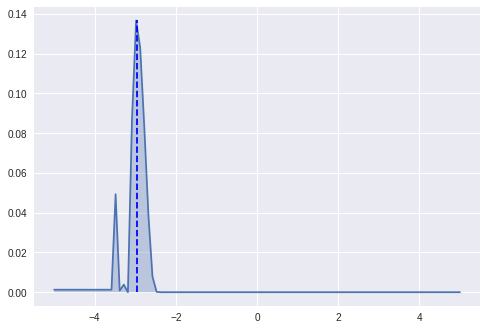

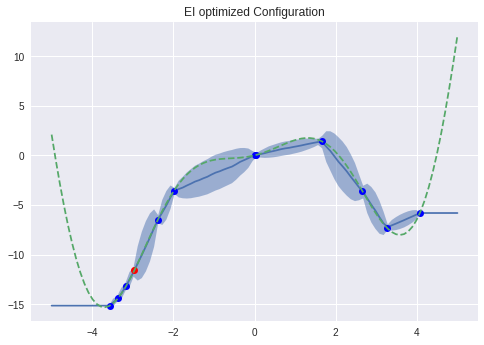

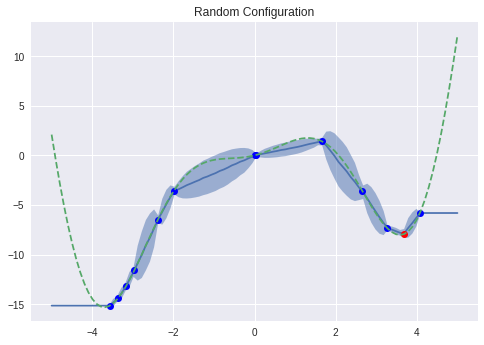

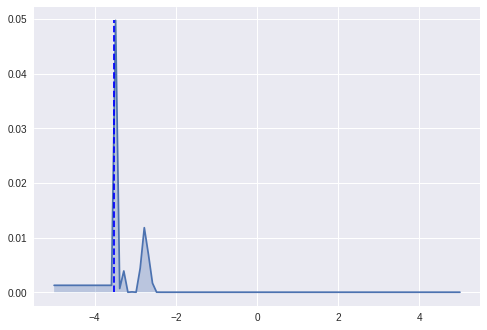

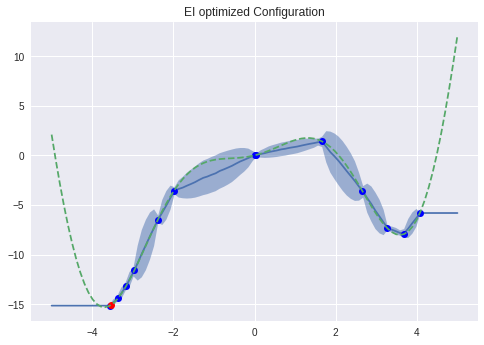

In [48]:
from smac.optimizer.acquisition import EI

for i in range(1,15):
  if i % 2 == 1:
    title_ = "Random Configuration"
  else:
    title_ = "EI optimized Configuration"
    
  # ensure that model is trained with all data points
  X, Y = smac.solver.rh2EPM.transform(runhistory)
  x_smac_ = np.array([[x] for x in x_smac[:i]])
  y_smac_ = np.array([[y] for y in y_smac[:i]])

  model.train(x_smac_, y_smac_)

  # scale x_points into hypercube since SMAC does the same internally
  x_points_ = np.array([[x] for x in x_points])

  # get predictions (mean and variances)
  y_mean, y_var = model.predict(x_points_)
  #if i == 4:
  #  preds_per_tree = model.rf.all_leaf_values(np.array([-2.1]))
  #  p = []
  #  for pred_t in preds_per_tree:
  #    #print(pred_t)
  #    p.append(pred_t[0])
  #  print(model.rf.predict_mean_var(np.array([-2.1])))
  #  print(np.std(p))
  y_mean = y_mean[:,0]
  y_std = np.sqrt(y_var)[:,0]

  # plot predictions
  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  ax1.plot(x_points,y_mean)
  ax1.fill_between(x_points, y_mean-y_std, 
                   y_mean+y_std,alpha=0.5)
  ax1.plot(x_smac[:i-1], y_smac[:i-1], 'bo')
  ax1.plot(x_smac[i-1], y_smac[i-1], 'ro')
  ax1.plot(x_points, y_points, '--')
  plt.title(title_)
  
  if i % 2 == 1:
    # plot acquisition function for next iteration
    acq_func = EI(model=model)
    acq_func.update(model=model, eta=np.min(y_smac[:i]))

    acq_values = acq_func._compute(X=x_points_)[:,0]

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    ax1.plot(x_points, acq_values)
    ax1.plot([x_smac[i],x_smac[i]], [0,np.max(acq_values)], 'b--')
    ax1.fill_between(x_points,0,acq_values,alpha=.3)
  